In [23]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime

In [15]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
print(X.shape)
K, N, T = X.shape

(108, 218, 61)


In [16]:


X_centered = X - jnp.mean(X, axis=0)                #(K, N, T) - (N, T) = (K, N, T)
A = jnp.swapaxes(X_centered, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                                 #(N, K*T)

In [17]:
def K_X_Y_diagonal(X, Y, sigma_sqrd):
    """For two spatial patterns X and Y, the kernel k(x_i,y_i) is equal to sum_i sigma_i^2 x_i y_i"""
    return jnp.dot(X.T * sigma_sqrd, Y) 

def K_X_Y_identity(X, Y):
    return jnp.dot(X.T, Y) 

In [18]:
K_A_X = K_X_Y_identity(A, X)                                     #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [21]:
def single_pair_loss(alpha_H, K_A_X, id_1, id_2):
    K_A_X_i = K_A_X[:,id_1,:]
    K_X_A_i = K_A_X[:,id_2,:].T
    
    Q = alpha_H.T @ K_A_X_i @ K_X_A_i @ alpha_H                         #(KT,D).T @ (KT,T) and (T,KT) @ (KT,D) --> (D,T) @ (T,D) --> (D,D)
    QQ_product = jnp.einsum('ij,lm->im', Q, Q)
    S_pair = jnp.trace(Q)**2 - jnp.trace(QQ_product)
    return S_pair 

def loss(alpha_tilde, P, S, K_A_X, key, i,D=3):  
    K, N, T = X.shape
    
    alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * alpha_tilde_QR

    alpha_reshaped = alpha.reshape(K,T,D)                           #(K, T, D)
    mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)        #(1, T, D)
    alpha_H = (alpha_reshaped - mean).reshape(K*T,D)                #(K*T,D)

    num_pairs = 100  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(alpha_H, K_A_X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (K**2) ) * jnp.sum(batched_loss)
    if i % 10 == 0:
        jax.debug.print("iteration: {}, -S: {}", i, -S)
    return -S

def update(alpha_tilde, P, S, K_A_X, optimizer, opt_state, key,i):
    grad_loss = grad(loss)(alpha_tilde, P, S, K_A_X, key,i)
  
    updates, opt_state_updated = optimizer.update(grad_loss, opt_state, alpha_tilde)
    alpha_tilde_updated = optax.apply_updates(alpha_tilde, updates)
    return alpha_tilde_updated, opt_state_updated

def optimize_params(P, S, K_A_X, iterations=1000, learning_rate=0.001, D=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    
    alpha_tilde = random.normal(key, (K*T, D))
    
    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(alpha_tilde)
    
    for i in range(iterations):
        alpha_tilde, opt_state = update(alpha_tilde, P, S, K_A_X, optimizer, opt_state, keys[i],i)

    return alpha_tilde

optimized_params = optimize_params(P, S, K_A_X)

-S: 8.991330209575731e+16
-S: -3.333943452709683e+16
-S: -1.4810361496600576e+17
-S: -5.0592584443101184e+17
-S: -2.2856578998730752e+18
-S: -6.303573279563055e+18
-S: -1.3750862952385217e+19
-S: -4.096982195428236e+19
-S: -8.13752250076087e+19
-S: -1.3557550116524524e+20
-S: -2.4216671473803618e+20
-S: -3.946285858514094e+20
-S: -5.168162047384355e+20
-S: -8.343268042362407e+20
-S: -1.207752548595106e+21
-S: -1.9360825616328106e+21
-S: -2.729566150479684e+21
-S: -3.708093922290933e+21
-S: -4.617746456150945e+21
-S: -6.36191600096271e+21
-S: -8.050721388180326e+21
-S: -7.740920458663369e+21
-S: -1.1039998025746468e+22
-S: -1.204120114020655e+22
-S: -1.3146079369888516e+22
-S: -1.540712732540857e+22
-S: -1.4410725048151263e+22
-S: -2.015187444662643e+22
-S: -1.564239649584231e+22
-S: -2.0090503894504254e+22
-S: -1.8519551517085437e+22
-S: -2.2927159170198344e+22
-S: -2.3360558576738717e+22
-S: -2.4354241805720998e+22
-S: -2.4526918822633637e+22
-S: -2.8371472939533803e+22
-S: -3.1553403

In [24]:
now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')
file_name = 'outputs/kernel_SCA/optimized_a_' + date_time_str
np.save(file_name, optimized_params)

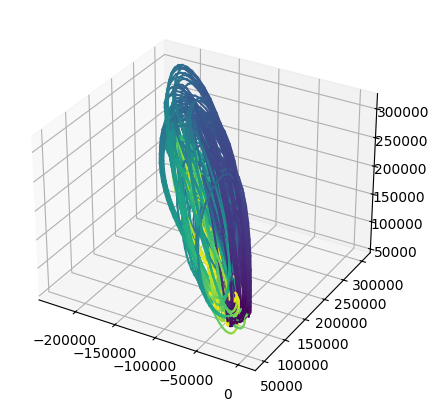

In [25]:
optimized_alpha_tilde_QR, _ = jnp.linalg.qr(optimized_params) 
optimized_alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * optimized_alpha_tilde_QR
phi_U = jnp.dot(A, optimized_alpha)

phi_Y = jnp.einsum('ji,kjl->kil', phi_U, X)         #(K,d,T)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = phi_Y.shape[-1]
indices_to_plot = np.arange(0,phi_Y.shape[0],1)

for i in indices_to_plot:
    x = phi_Y[i, 0, :]  
    y = phi_Y[i, 1, :] 
    z = phi_Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))


In [26]:
def make_frame(angle):
    ax.view_init(30, angle)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0, 360, 2) 
frames = [make_frame(angle) for angle in angles]

gif_path = date_time_str + "_trajectories_rotation_test.gif"
imageio.mimsave(gif_path, frames, fps=20)

gif_path

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_76715/105152096.py:4: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


'15052024_155852_trajectories_rotation_test.gif'

ENDS HERE